# Association Mining

The goal in this problem set is to design and code an algorithm for generating association rules based on the apriori algorithm. The dataset that you will use to mine for association rules is a synthetic dataset containing over 1500 transactions. The format of the data is as follows:

* Each row in the file represents a single transaction
* Each transaction contains one or more letters representing items
* The number of each item is immaterial for mining, so each unique letter will appear at most once in a transaction
    - Note: this means you cannot just read the data into a dataframe, because the data is not columnar

Example:

A

A, C, E

B, D

The above represents 3 transactions, where the third transaction contained at least one of each for items B and D.

## Problems

1. Write a scipt to read the data file 'itemsets.dat' into a list of lists
    - one inner list of items for each transaction
    - the .dat file is essentially just a text file
2. For a bit of EDA: 
    * create a script that plots the proportions of single items sold
    * plot the counts for the different itemset sizes
3. Create a function to compute support for a given itemset from a transaction
4. Write an apriori function that handles the pruning and generation of frequent itemsets
    - should return a dict of frequent itemsets as keys, and their support as values
    - must have a method for setting a minimum support value to determine frequent itemsets
    - hint: use sets and frozensets <- dict keys cant be mutable objects
5. Create a function that uses the frequent itemsets to generate association rules
    - must have a min confidence level as a parameter
        + do not keep rules that fall under this threshold
    - return dict of rules with string for keys
        + string key will take a form like: "{'A', 'B'} -> {'C'}"
        + values must be a dict containing metric:value pairs where metrics include support, confidence, and lift
    - return dataframe of rules with the following columns
        + antecedent, consequent, support, confidence, lift
    - Note: the support is for the entire set: antecedent union consequent
6. Create a scatter plot to analyze the association rules
    - one axis for antecedent and one for consequent
    - set marker size based on support (use a multiplier to scale these up)
    - set marker color based on lift
    - hint: convert axes columns to numeric codes using `.astype('category').cat.codes`
7. How should you interpret the lift values that are less than 1?

## 1. Write a scipt to read the data file 'itemsets.dat' into a list of lists
- one inner list of items for each transaction
- the .dat file is essentially just a text file

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('itemsets.dat') as f:
    transactions = []
    for row in f:
        transactions.append(row.strip().split(','))

In [3]:
transactions[0:5]

[['A', 'C'], ['A', 'C'], ['D', 'E'], ['A', 'C', 'D'], ['A', 'E']]

## 2. For a bit of EDA: 
* create a script that plots the proportions of single items sold
* plot the counts for the different itemset sizes

In [4]:
items_counts = {}
for tran in transactions:
    for item in tran:
        if item in items_counts:
            items_counts[item] += 1
        else:
            items_counts[item] = 1

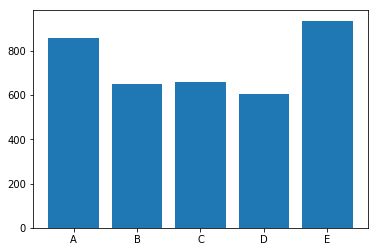

In [5]:
plt.bar(items_counts.keys(), items_counts.values());

In [6]:
itemsets_sizes = {}
for tran in transactions:
    tran = frozenset(tran)
    if tran in itemsets_sizes:
        itemsets_sizes[tran] += 1
    else:
        itemsets_sizes[tran] = 1

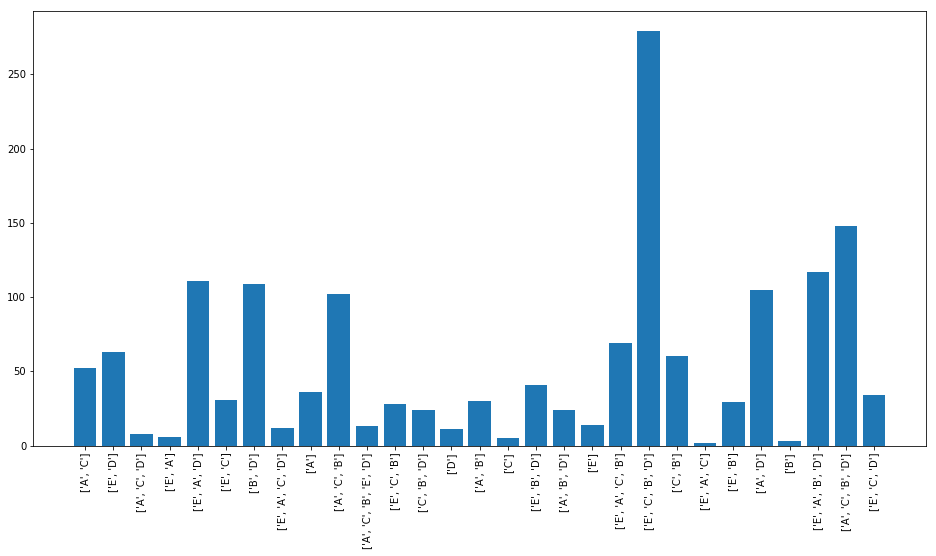

In [7]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(itemsets_sizes.keys(), itemsets_sizes.values())
ax.set_xticklabels([list(itemset) for itemset in itemsets_sizes.keys()], rotation='vertical');

## 3. Create a function to compute support for a given itemset from a transaction

In [8]:
def support_count(trans, itemset):
    count = 0
    for tran in trans:
        if set(itemset).issubset(set(tran)):
            count += 1
    return count

In [9]:
print(support_count(transactions, ['A']))
print(support_count(transactions, ['A', 'C']))
print(support_count(transactions, ['F']))

860
344
0


In [10]:
def support(trans, itemset):
    return support_count(trans, itemset) / len(trans)

In [11]:
print(support(transactions, ['A']))
print(support(transactions, ['A', 'C']))
print(support(transactions, ['F']))

0.5491698595146871
0.21966794380587484
0.0


## 4. Write an apriori function that handles the pruning and generation of frequent itemsets
- should return a dict of frequent itemsets as keys, and their support as values
- must have a method for setting a minimum support value to determine frequent itemsets
- hint: use sets and frozensets <- dict keys cant be mutable objects

In [12]:
def generate_supsets(items, sets):
    sups = {}
    for s in sets:
        for item in items:
            sup = frozenset(s.union(item))
            if sup != s and sup not in sups:
                sups[sup] = 1
    return list(sups.keys())

In [13]:
def apriori(trans, minsupp):
    frequent_itemsets = {}
    # get items list
    items = list(set([item for tran in trans for item in tran]))
    # initialize list of itemsets to check
    curr_sets = items
    # iterate till max itemset length
    for i in range(len(items)):
        # print(i, curr_sets)
        # initialize candidates itemsets for generation of supsets
        next_sets = []
        # initialize current iteration unfrequent itemsets list
        unfrequent = []
        for s in curr_sets:
            supp = support(trans, s)
            # print(s, supp)
            # if we are over minsupp add itemset to frequent list and to supsets generation candidates
            if supp >= minsupp:
                frequent_itemsets[frozenset(s)] = supp
                next_sets.append(frozenset(s))
            #else add to unfrequent list
            else:
                unfrequent.append(frozenset(s))
        # if this is the first iteration update items list in order to optimize supsets generation
        if i == 0:
            items = [item for item in items if item not in unfrequent]
        # generate supsets and exclude those that contain an unfrequent itemset
        curr_sets = generate_supsets(items, next_sets)
        for unfr in unfrequent:
            curr_sets = [s for s in curr_sets if not unfr.issubset(s)]
        # print(next_sets)
        # print(unfrequent)
        # print(curr_sets)
        if len(curr_sets) == 0:
            break
    return frequent_itemsets

In [14]:
apriori(transactions, 0.1)

{frozenset({'A'}): 0.5491698595146871,
 frozenset({'C'}): 0.4220945083014049,
 frozenset({'B'}): 0.4144316730523627,
 frozenset({'E'}): 0.5977011494252874,
 frozenset({'D'}): 0.3876117496807152,
 frozenset({'A', 'C'}): 0.21966794380587484,
 frozenset({'A', 'B'}): 0.1826309067688378,
 frozenset({'A', 'E'}): 0.2796934865900383,
 frozenset({'A', 'D'}): 0.13218390804597702,
 frozenset({'B', 'C'}): 0.2247765006385696,
 frozenset({'C', 'E'}): 0.2164750957854406,
 frozenset({'B', 'E'}): 0.1583652618135377,
 frozenset({'B', 'D'}): 0.18518518518518517,
 frozenset({'D', 'E'}): 0.21966794380587484,
 frozenset({'A', 'B', 'C'}): 0.10600255427841634,
 frozenset({'B', 'C', 'E'}): 0.11558109833971902}

## 5. Create a function that uses the frequent itemsets to generate association rules
- must have a min confidence level as a parameter
    + do not keep rules that fall under this threshold
- return dict of rules with string for keys
    + string key will take a form like: "{'A', 'B'} -> {'C'}"
    + values must be a dict containing metric:value pairs where metrics include support, confidence, and lift
- return dataframe of rules with the following columns
    + antecedent, consequent, support, confidence, lift
- Note: the support is for the entire set: antecedent union consequent

In [15]:
def calc_metrics(trans, X, Y):
    supp = support(trans, X.union(Y))
    supp_X = support(trans, X)
    supp_Y = support(trans, Y)
    conf = supp / supp_X
    lift = supp / (supp_X*supp_Y)
    return conf, lift, supp

In [16]:
def generate_subsets(items, sets):
    subs = {}
    for s in sets:
        for item in items:
            sup = frozenset(s.difference(item))
            if sup != s and sup not in subs:
                subs[sup] = 1
    return list(subs.keys())

In [17]:
def association_rules(trans, frequent, minconf):
    rules = {}
    # get items list
    items = list(frequent)
    # initialize list of antecedents to check
    curr_antecedents = generate_subsets(items, [frequent])
    # iterate till itemset length - 1
    for i in range(len(frequent)-1):
        # print(i, curr_rules)
        # initialize candidates itemsets for generation of subsets
        next_antecedents = []
        # initialize current iteration unfrequent itemsets list
        unconfident = []
        for ant in curr_antecedents:
            cons = set(items).difference(ant)
            conf, lift, supp = calc_metrics(trans, ant, cons)
            # print(ant, conf)
            # if we are over minconf add rule to rules list and to subsets generation candidates
            if conf >= minconf:
                rule_ant = ', '.join('{}'.format(a) for a in (list(ant)))
                rule_cons = ', '.join('{}'.format(c) for c in (list(cons)))
                rule = '{{{}}}->{{{}}}'.format(rule_ant, rule_cons)
                metrics = {}
                metrics['confidence'] = conf
                metrics['lift'] = lift
                metrics['support'] = supp
                rules[rule] = metrics
                next_antecedents.append(frozenset(ant))
            #else add to unconfident list
            else:
                unconfident.append(frozenset(ant))
        # generate subsets and exclude those that are contained in an unconfident rule
        curr_antecedents = generate_subsets(items, next_antecedents)
        for uncf in unconfident:
            curr_antecedents = [ant for ant in curr_antecedents if not uncf.issuperset(ant)]
        # print(next_antecedents)
        # print(unconfident)
        # print(curr_antecedents)
        if len(curr_antecedents) == 0:
            break
    return rules

In [18]:
association_rules(transactions, frozenset({'A', 'B', 'C'}), 0.2)

{'{A, B}->{C}': {'confidence': 0.5804195804195804,
  'lift': 1.3750938924917742,
  'support': 0.10600255427841634},
 '{A, C}->{B}': {'confidence': 0.4825581395348837,
  'lift': 1.1643852796789333,
  'support': 0.10600255427841634},
 '{B}->{A, C}': {'confidence': 0.2557781201848998,
  'lift': 1.1643852796789333,
  'support': 0.10600255427841634},
 '{C, B}->{A}': {'confidence': 0.47159090909090906,
  'lift': 0.8587341437632134,
  'support': 0.10600255427841634},
 '{C}->{A, B}': {'confidence': 0.2511346444780635,
  'lift': 1.3750938924917742,
  'support': 0.10600255427841634}}

In [19]:
def get_all_rules(trans, frequent_itemsets, minconf):
    rules_dict = {}
    for frequent in frequent_itemsets:
        rules = association_rules(trans, frequent, minconf)
        rules_dict.update(rules)
    rules_df = pd.DataFrame(rules_dict).T.reset_index()
    rules_df['antecedent'] = rules_df['index'].apply(lambda x: x.split('->')[0])
    rules_df['consequent'] = rules_df['index'].apply(lambda x: x.split('->')[1])
    rules_df.drop('index', axis=1, inplace=True)
    return rules_dict, rules_df

In [20]:
frequent_itemsets = apriori(transactions, 0.1)

In [21]:
rules_dict, rules_df = get_all_rules(transactions, frequent_itemsets, 0.3)

In [22]:
rules_dict

{'{A, B}->{C}': {'confidence': 0.5804195804195804,
  'lift': 1.3750938924917742,
  'support': 0.10600255427841634},
 '{A, C}->{B}': {'confidence': 0.4825581395348837,
  'lift': 1.1643852796789333,
  'support': 0.10600255427841634},
 '{A}->{B}': {'confidence': 0.3325581395348837,
  'lift': 0.8024438312968073,
  'support': 0.1826309067688378},
 '{A}->{C}': {'confidence': 0.4,
  'lift': 0.9476550680786686,
  'support': 0.21966794380587484},
 '{A}->{E}': {'confidence': 0.5093023255813953,
  'lift': 0.8521019677996421,
  'support': 0.2796934865900383},
 '{B}->{A}': {'confidence': 0.4406779661016949,
  'lift': 0.8024438312968073,
  'support': 0.1826309067688378},
 '{B}->{C}': {'confidence': 0.5423728813559322,
  'lift': 1.284956024513449,
  'support': 0.2247765006385696},
 '{B}->{D}': {'confidence': 0.4468412942989214,
  'lift': 1.1528063704647624,
  'support': 0.18518518518518517},
 '{B}->{E}': {'confidence': 0.38212634822804314,
  'lift': 0.6393267749199952,
  'support': 0.1583652618135377

In [23]:
rules_df

,confidence,lift,support,antecedent,consequent
0,0.580420,1.375094,0.106003,"{A, B}",{C}
1,0.482558,1.164385,0.106003,"{A, C}",{B}
2,0.332558,0.802444,0.182631,{A},{B}
3,0.400000,0.947655,0.219668,{A},{C}
4,0.509302,0.852102,0.279693,{A},{E}
5,0.440678,0.802444,0.182631,{B},{A}
6,0.542373,1.284956,0.224777,{B},{C}
7,0.446841,1.152806,0.185185,{B},{D}
8,0.382126,0.639327,0.158365,{B},{E}
9,0.471591,0.858734,0.106003,"{C, B}",{A}


## 6. Create a scatter plot to analyze the association rules
- one axis for antecedent and one for consequent
- set marker size based on support (use a multiplier to scale these up)
- set marker color based on lift
- hint: convert axes columns to numeric codes using `.astype('category').cat.codes`

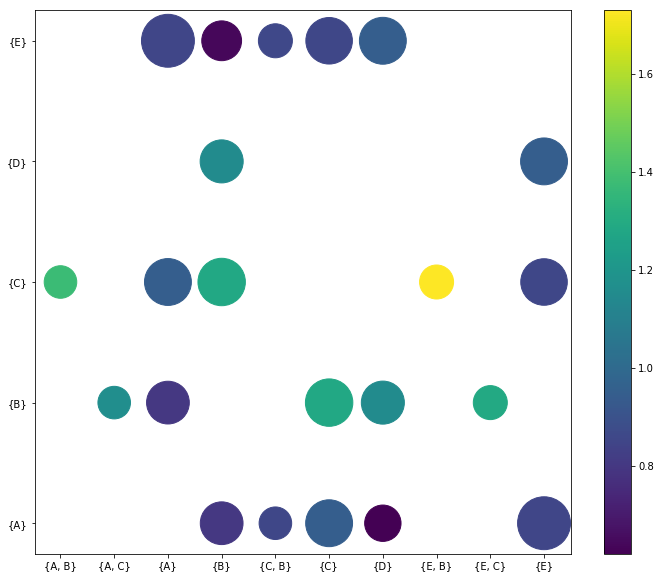

In [24]:
x = rules_df['antecedent'].astype('category')
y = rules_df['consequent'].astype('category')

fig, ax = plt.subplots(figsize=(12, 10))
sct = ax.scatter(x.cat.codes, y.cat.codes, s=rules_df['support']*10000, c=rules_df['lift'])
ax.xaxis.set_major_locator(plt.MaxNLocator(len(x.unique())))
ax.xaxis.set_ticklabels(np.append([''], x.cat.categories))
ax.yaxis.set_major_locator(plt.MaxNLocator(len(y.unique())))
ax.yaxis.set_ticklabels(np.append([''], y.cat.categories))
fig.colorbar(sct);

## 7. How should you interpret the lift values that are less than 1?

Given a rule $X \rightarrow Y$, lift is defined as the support of the union of $X$ and $Y$ divided by the support of $X$ multiplied by the support of $Y$:

$$lift(X \rightarrow Y) = \frac{supp(X \cup Y)}{supp(X) \cdot supp(Y)}.$$

Furthermore, the rule we are considering is over a certain threshold for confidence, which is defined as

$$conf(X \rightarrow Y) = \frac{supp(X \cup Y)}{supp(X)},$$

and so

$$lift(X \rightarrow Y) = \frac{conf(X \rightarrow Y)}{supp(Y)}.$$

so a rule with lift less than 1 can be interpreted as a rule where the support of consequent is greater than the confidence of the rule. That is to say that we have a rule that has confidence over the threshold but the weight in the high confidence value is due in good part to the fact that the consequent has high support, in other words the rule happens frequently because the consequent is frequent.